# JSMA Adversarial Perturbation Technique

## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading MobileNet

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

##### Helper Functions

In [3]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

def display_images(image, description, label, confidence):
    
    plt.figure()
    
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
    
    plt.show()

## Original Image

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 0s 262ms/step


In [5]:
get_imagenet_label(image_probs)

('n02099712', 'Labrador_retriever', 0.4181851)

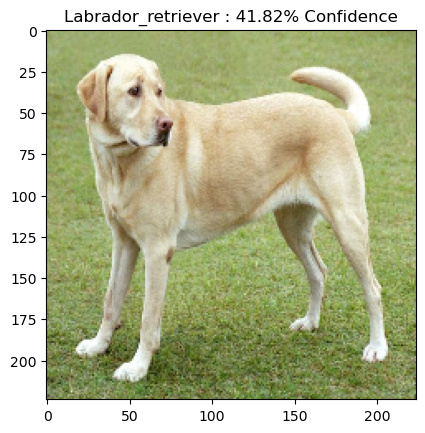

In [6]:
plt.figure()

plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))

plt.show()

## Creating an Adversarial Image using JSMA

In [7]:
def generate_adversarial_jsma(input_image, target_class, model, epsilon=0.1, theta=1.0, gamma=0.1, max_iters=100):
    input_tensor = input_image
#     original_prediction = model(input_tensor).numpy().argmax()

    # Initialize perturbed image as a copy of the original image
    perturbed_image = np.copy(input_image)

    for _ in range(max_iters):
        with tf.GradientTape() as tape:
            tape.watch(input_tensor)
            prediction = model(input_tensor)
            loss = -tf.math.log(prediction[0, target_class])
        gradients = tape.gradient(loss, input_tensor)

        salience = tf.abs(gradients).numpy()

        pixels_to_perturb = salience.argsort(axis=None)[-int(np.prod(input_image.shape) * gamma):]

        perturbed_image.flat[pixels_to_perturb] += theta

        perturbed_image = np.clip(perturbed_image, input_image - epsilon, input_image + epsilon)
        perturbed_image = np.clip(perturbed_image, 0, 1) 
        return perturbed_image
    
    return None  


In [8]:
def jsma(model, image, epsilon):
    perturbed_image = generate_adversarial_jsma(input_image=image,target_class=208,model=model,epsilon=epsilon)
    predictions = model.predict(perturbed_image)
    return predictions, perturbed_image

In [9]:
epsilons = [0, 0.45, 0.5, 0.55, 0.6]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
descriptions

['Input',
 'Epsilon = 0.450',
 'Epsilon = 0.500',
 'Epsilon = 0.550',
 'Epsilon = 0.600']

1/1 [==============================] - 0s 21ms/step


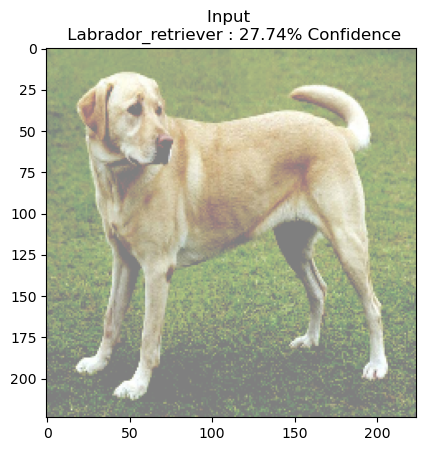

1/1 [==============================] - 0s 22ms/step


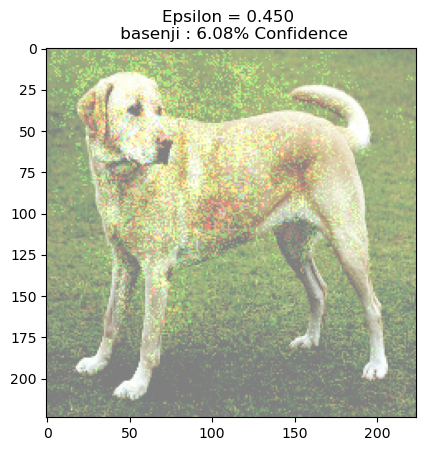

1/1 [==============================] - 0s 23ms/step


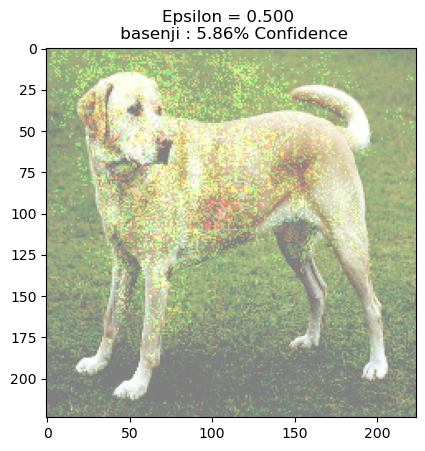

1/1 [==============================] - 0s 22ms/step


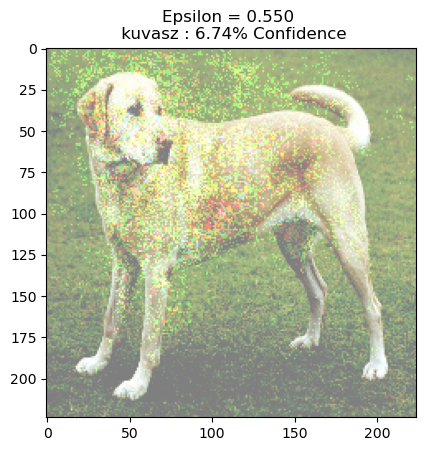

1/1 [==============================] - 0s 24ms/step


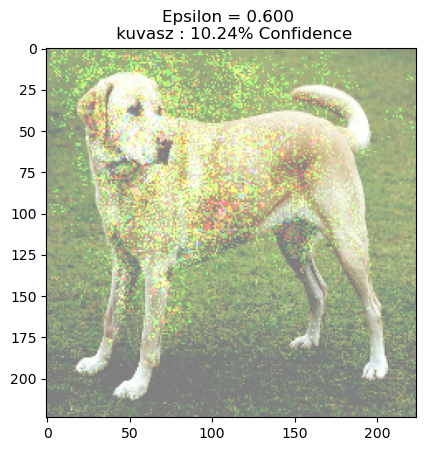

In [10]:
for i,e in enumerate(epsilons):
    
    # Generate adversarial example using CTC
    results, perbuted_image = jsma(model=pretrained_model, image=image, epsilon=e)
    results = get_imagenet_label(results)
    
    display_images(image=perbuted_image, description=descriptions[i],label=results[1],confidence=results[2])